# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Необходимо довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

`Суть проекта` - Даны данные банка "Бета - Банк" по клиентам. Клиенты начали покидать немного но ежемесячно банк. Нужно построить модель с предельно большим значением F1-меры.

`Конечная цель проекта` - Выбрать наиболее точную модель и довести её F1-меру до уровня выше 0.59.

Начнем с импортирования всех нужных библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve 
from tqdm import tqdm
import itertools

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
from pandas.core.common import SettingWithCopyWarning

In [2]:
data = pd.read_csv('Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data = data.fillna(0)
display(data.head())
data.describe()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Целевой признак - столбец `Exited`

In [4]:
#прямое кодирование и разделение данных
data_ohe = pd.get_dummies(data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1), drop_first=True)
features = data_ohe.drop(['Exited'], axis = 1)
target = data_ohe['Exited']
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345, stratify=target_valid)

In [5]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#стандартизация количественных признаков
col_scaler = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()

scaler.fit(features_train[col_scaler])
features_train[col_scaler] = scaler.transform(features_train[col_scaler])
scaler.fit(features_valid[col_scaler])
features_valid[col_scaler] = scaler.transform(features_valid[col_scaler])
scaler.fit(features_test[col_scaler])
features_test[col_scaler] = scaler.transform(features_test[col_scaler])

In [6]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


## Исследование задачи

Баланс классов:

In [7]:
print(f'Mean:{target.mean()}')
print(f'Std:{target.std()}')

Mean:0.2037
Std:0.40276858399484955


Баланс составляет `20% : 80%`

Создадим модель `Случайного леса`:

In [8]:
best_model_forest = None
best_result_forest = 0

for params in tqdm(itertools.product(range(10, 51, 5), range(1, 16))):
    est, depth = params
    model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result_forest:
        best_model_forest = model
        best_result_forest = result
        best_params_forest = params
        
print(f'F1-мера = {round(best_result_forest, 5)}')
print(f'Кол-во деревьев: {best_params_forest[0]}, Глубина: {best_params_forest[1]}')

135it [00:22,  6.03it/s]

F1-мера = 0.62925
Кол-во деревьев: 45, Глубина: 15


Модель `Дерево решений`

In [9]:
best_model_tree = None
best_result_tree = 0

for params in tqdm(itertools.product(range(1, 16), range(1, 5))):
    depth, min_s_l = params
    model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_s_l, random_state=12345)
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_params_tree = params

print(f'F1-мера = {round(best_result_tree, 5)}')
print(f'Глубина: {best_params_tree[0]}, Мин. кол-во делений: {best_params_tree[1]}')

60it [00:01, 43.78it/s]

F1-мера = 0.59538
Глубина: 7, Мин. кол-во делений: 2


Модель `Логистическая регрессия`

In [10]:
model_logistic = LogisticRegression(solver='liblinear', random_state=12345)
model_logistic.fit(features_train, target_train) 
predictions_valid_log = model_logistic.predict(features_valid) 
result_logistic = f1_score(target_valid, predictions_valid_log) 

print(f'F1-мера логистической регрессии: {round(result_logistic, 5)}')

F1-мера логистической регрессии: 0.31079


<b>Вывод

F1-меры моделей:
1. Случайный лес = `0.62925` | Деревья=45, Глубина=15
2. Дерево решений = `0.59538` | Глубина=7, Деления=2
3. Логистическая регрессия = `0.31079`

<b>Присутствует дисбаланс `20% : 80%`

## Борьба с дисбалансом

### Увелечение выборки

In [11]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target  == 1]
    
    features_up = pd.concat([features_zeros] + [features_ones] * repeat)
    target_up = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_up, target_up = shuffle(features_up, target_up, random_state=12345)
    
    return features_up, target_up

features_up, target_up = upsample(features_train, target_train, 4)
print(f'Дисбаланс данных: {round(target_up.mean(), 5)}')

Дисбаланс данных: 0.50569


Модель `Случайного леса`

In [12]:
best_model_forest_up = None
best_result_forest_up = 0

for params in tqdm(itertools.product(range(10, 51, 4), range(1, 16))):
    est, depth = params
    model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
    model.fit(features_up, target_up)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result_forest_up:
        best_model_forest_up = model
        best_result_forest_up = result
        best_params_forest_up = params
        
print(f'F1-мера = {round(best_result_forest_up, 5)}')
print(f'Кол-во деревьев: {best_params_forest_up[0]}, Глубина: {best_params_forest_up[1]}')


165it [00:53,  3.09it/s]

F1-мера = 0.65604
Кол-во деревьев: 42, Глубина: 11


Модель `Дерево решений`

In [13]:
best_model_tree_up = None
best_result_tree_up = 0

for params in tqdm(itertools.product(range(1, 16), range(1, 5))):
    depth, min_s_l = params
    model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_s_l, random_state=12345)
    model.fit(features_up, target_up)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result_tree_up:
        best_model_tree_up = model
        best_result_tree_up = result
        best_params_tree_up = params

print(f'F1-мера = {round(best_result_tree_up, 5)}')
print(f'Глубина: {best_params_tree_up[0]}, Мин. кол-во делений: {best_params_tree_up[1]}')

60it [00:02, 22.78it/s]

F1-мера = 0.57802
Глубина: 6, Мин. кол-во делений: 3


Модель `Логистическая регрессия`

In [14]:
model_logistic_up = LogisticRegression(solver='liblinear', random_state=12345)
model_logistic_up.fit(features_up, target_up) 
predictions_valid_log_up = model_logistic_up.predict(features_valid) 
result_logistic_up = f1_score(target_valid, predictions_valid_log_up) 

print(f'F1-мера логистической регрессии: {round(result_logistic_up, 5)}')

F1-мера логистической регрессии: 0.52459


<b>Вывод

Результаты увелечение выбороки (upsampling) - `было` | `стало`:
1. Случайный лес - `0.62925` | `0.65604`
2. Дерево решений - `0.59538` | `0.57802`
3. Логистическая регрессия - `0.31079` | `0.52459`

<b>Значение дисбаланса = 0.50569

### Уменьшение выборки

In [15]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_down = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_down = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_down, target_down = shuffle(features_down, target_down, random_state=12345)
    
    return features_down, target_down

features_down, target_down = downsample(features_train, target_train, 0.25)
print(f'Дисбаланс данных: {round(target_down.mean(), 5)}')

Дисбаланс данных: 0.50579


Модель `Случайного леса`

In [16]:
best_model_forest_down = None
best_result_forest_down = 0

for params in tqdm(itertools.product(range(10, 51, 5), range(1, 16))):
    est, depth = params
    model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
    model.fit(features_down, target_down)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result_forest_down:
        best_model_forest_down = model
        best_result_forest_down = result
        best_params_forest_down = params
        
print(f'F1-мера = {round(best_result_forest_down, 5)}')
print(f'Кол-во деревьев: {best_params_forest_down[0]}, Глубина: {best_params_forest_down[1]}')

135it [00:27,  4.97it/s]

F1-мера = 0.64008
Кол-во деревьев: 15, Глубина: 7


Модель `Дерево решений`

In [17]:
best_model_tree_down = None
best_result_tree_down = 0

for params in tqdm(itertools.product(range(1, 16), range(1, 5))):
    depth, min_s_l = params
    model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_s_l, random_state=12345)
    model.fit(features_down, target_down)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result_tree_down:
        best_model_tree_down = model
        best_result_tree_down = result
        best_params_tree_down = params

print(f'F1-мера = {round(best_result_tree_down, 5)}')
print(f'Глубина: {best_params_tree_down[0]}, Мин. кол-во делений: {best_params_tree_down[1]}')

60it [00:00, 72.74it/s] 

F1-мера = 0.59603
Глубина: 6, Мин. кол-во делений: 3


Модель `Логистической регрессии`

In [18]:
model_logistic_down = LogisticRegression(solver='liblinear', random_state=12345)
model_logistic_down.fit(features_up, target_up) 
predictions_valid_log_down = model_logistic_down.predict(features_valid) 
result_logistic_down = f1_score(target_valid, predictions_valid_log_down) 

print(f'F1-мера логистической регрессии: {round(result_logistic_down, 5)}')

F1-мера логистической регрессии: 0.52459


<b>Вывод

Результаты уменьшения выбороки (downsampling) - `обычная` | `увеличенная` | `уменьшенная`:
1. Случайный лес - `0.62925` | `0.65604` | `0.64008`
2. Дерево решений - `0.59538` | `0.57802` | `0.59603`
3. Логистическая регрессия - `0.31079` | `0.52459` | `0.52459`

<b>Значение дисбаланса = 0.50579


## Тестирование модели

При увеличенной выборке

In [19]:
features_up, target_up = upsample(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]), 4)
print(f'Дисбаланс: {round(target_up.mean(), 5)}')

Дисбаланс: 0.50582


In [20]:
model = RandomForestClassifier(n_estimators=best_params_forest_up[0], max_depth=best_params_forest_up[1], random_state=12345)
model.fit(features_up, target_up)
predicted_test = model.predict(features_test)
print(f'F1-мера = {round(f1_score(target_test, predicted_test), 5)}')

F1-мера = 0.60879


In [21]:
probabilities_test_up = model.predict_proba(features_test)
probabilities_one_test_up = probabilities_test_up[:, 1]
auc_roc_up = roc_auc_score(target_test, probabilities_one_test_up)
print(f'Area Under Curve ROC = {round(auc_roc_up, 5)}')

Area Under Curve ROC = 0.85551


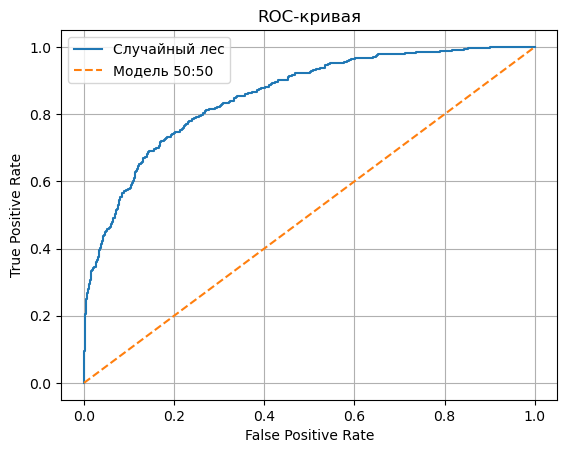

In [22]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_up) 

plt.plot(fpr, tpr, label='Случайный лес')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--', label='Модель 50:50')
plt.grid()
plt.legend()
plt.show()

При уменьшенной выборке

In [23]:
features_down, target_down = downsample(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]), 0.25)
print(f'Дисбаланс:{round(target_down.mean(), 5)}')

Дисбаланс:0.5059


In [29]:
model = RandomForestClassifier(n_estimators=best_params_forest_down[0], max_depth=best_params_forest_down[1], random_state=12345)
model.fit(features_down, target_down)
predicted_test = model.predict(features_test)
print(f'F1-мера = {round(f1_score(target_test, predicted_test), 5)}')

F1-мера = 0.57088


In [25]:
probabilities_test_down = model.predict_proba(features_test)
probabilities_one_test_down = probabilities_test_down[:, 1]
auc_roc_down = roc_auc_score(target_test, probabilities_one_test_down)
print(f'Area Under Curve ROC = {round(auc_roc_down, 5)}')

Area Under Curve ROC = 0.84717


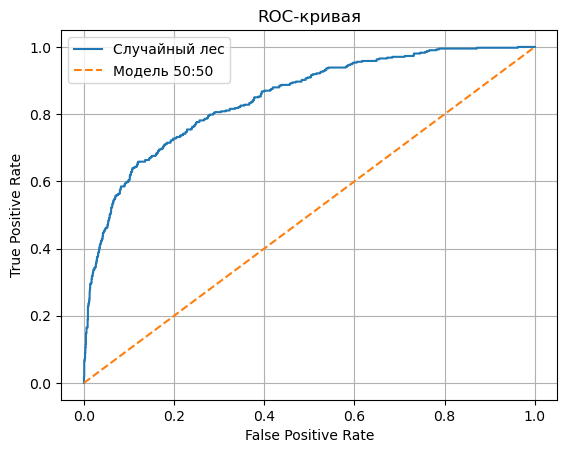

In [27]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_down) 

plt.plot(fpr, tpr, label='Случайный лес')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--', label='Модель 50:50')
plt.grid()
plt.legend()
plt.show()

# Вывод

После предварительной обработки данных, лучшее качество показала обученная модель `Случайного леса` при параметрах: n_estimators=42, max_depth=11 (увеличенная обучающая выборка).

F1-мера = `0.60879`
AUC ROC = `0.85551`

Дизбаланс в увеличенной обучающей выборке = `0.50582`